# Downloading the pip package

In [41]:
from ADDA.data import augmentations

train_transform, test_transform = augmentations.supervised_augmentations()


# Preparations

In [42]:
import ADDA
import torch
import matplotlib.pyplot as plt

#plt.style.use('seaborn')

Define path to source and target domain data:

In [43]:
import numpy as np
model_II_train_path = "II_train.npy"
model_II_train_labels_path ="II_train_label.npy"

model_II_val_path = "II_test.npy"
model_II_val_label_path = "II_test_label.npy"

model_II_test_path = "II_test2.npy"
model_II_test_labels_path =  "II_test2_label.npy"

print(np.load(model_II_train_path ).shape)

(9000, 1, 64, 64)


In [ ]:
II_test_HR=torch.from_numpy(np.load(model_II_test_path))
II_test_LR=torch.nn.functional.interpolate(II_test_HR, size=(32, 32), mode='bilinear', align_corners=False)
II_test_LR=II_test_LR.numpy()
#I_train_LR=torch.nn.functional.interpolate(I_train_LR, size=(150, 150), mode='bilinear', align_corners=False)


In [35]:
II_train_HR=torch.from_numpy(np.load(model_II_train_path))
II_train_LR=torch.nn.functional.interpolate(II_train_HR, size=(32, 32), mode='bilinear', align_corners=False)
II_train_LR=II_train_LR.numpy()
#I_train_LR=torch.nn.functional.interpolate(I_train_LR, size=(150, 150), mode='bilinear', align_corners=False)


In [36]:
print(II_train_LR.shape)

(9000, 1, 32, 32)


In [33]:
II_val_HR=torch.from_numpy(np.load(model_II_val_path))
II_val_LR=torch.nn.functional.interpolate(II_val_HR, size=(32, 32), mode='bilinear', align_corners=False)
II_val_LR=II_val_LR.numpy()
#I_train_LR=torch.nn.functional.interpolate(I_train_LR, size=(150, 150), mode='bilinear', align_corners=False)


In [51]:
import torch.nn as nn
class Conv(nn.Module):
  def __init__(self, in_c, out_c, **kwargs):
      super().__init__()
      self.cnn = nn.Conv2d(in_c, out_c, **kwargs)
      self.actication = nn.PReLU(num_parameters=out_c)

  def forward(self, x):
      x = self.cnn(x)
      x = self.actication(x)
      return x

class Upsample(nn.Module):
  def __init__(self, in_c, scale_factor):
      super().__init__()
      self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, kernel_size=3, stride=1, padding=1)
      self.pixel_shuffle = nn.PixelShuffle(scale_factor)
      self.activation = nn.PReLU(num_parameters=in_c)

  def forward(self, x):
      x = self.conv(x)
      x = self.pixel_shuffle(x)
      x = self.activation(x)
      return x

class RBlock(nn.Module):
  def __init__(self, in_c):
      super().__init__()
      self.b1 = Conv(in_c, in_c, kernel_size=3, stride=1, padding=1)
      self.b2 = Conv(in_c, in_c, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
      b1_output = self.b1(x)
      b2_output = self.b2(b1_output)
      return b2_output + x

class Generator(nn.Module):
  def __init__(self, in_c=1, out_c=64, no_blocks=18):
      super().__init__()
      self.first_conv = Conv(in_c, out_c, kernel_size=9, stride=1, padding=4)
      res_blocks = []
      for _ in range(no_blocks):
          res_blocks.append(RBlock(64))
      self.res_blocks = nn.Sequential(*res_blocks)
      self.conv1 = Conv(out_c, out_c, kernel_size=3, stride=1, padding=1)

      self.upsampling = Upsample(out_c, scale_factor=2)
      self.last_conv = nn.Conv2d(out_c, in_c, kernel_size=3, stride=1, padding=1)

  def forward(self,x):
      first_conv = self.first_conv(x)
      x = self.res_blocks(first_conv)
      x = self.conv1(x) + first_conv
      x = self.upsampling(x)
      x = self.last_conv(x)
      return x
     
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator().to(device)
model = model.to(device)
best = torch.load('./Model/SRResNet.pth')
model.load_state_dict(best)

/tmp/ipykernel_3898795/2468522937.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load('./Model/SRResNet.pth')


<All keys matched successfully>

In [52]:
from tqdm import tqdm
out = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for i in tqdm(range(II_test_LR.shape[0])):
        data = torch.from_numpy(II_test_LR[i][None,:,:,:]).float()
        data = data.to(device)
        recon = model(data)
        out.append(recon.cpu().detach().numpy()[0])
test_pred = np.asarray(out).astype(np.float32)

100%|██████████| 1800/1800 [00:05<00:00, 307.99it/s]


In [53]:
np.save('II_test_SR2.npy', test_pred)

In [7]:
from ADDA.algorithms import supervised
from ADDA.networks import resnet
Resnet = torch.load('resnet.pt', weights_only=False)
encoder = resnet.Encoder('18')
classifier = resnet.Classifier()

Resnet1 = supervised.Supervised(encoder,classifier)
Resnet1.encoder.load_state_dict(Resnet['encoder_weights'])
Resnet1.classifier.load_state_dict(Resnet['classifier_weights'])

/home/koo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/koo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

# Supervised learning

## Loading data

In [13]:
from ADDA.data import augmentations

train_transform, test_transform = augmentations.supervised_augmentations()

We then create dataloaders from our data:

In [56]:
from ADDA.data.dataset import get_dataloader

bs = 100
source_dataloader_train = get_dataloader(model_II_train_path, model_II_train_labels_path,train_transform, bs)
source_dataloader_val = get_dataloader(model_II_val_path, model_II_val_label_path, test_transform, bs)
source_dataloader_test = get_dataloader(model_II_test_path, model_II_test_labels_path, test_transform, bs)
source_dataloader_HR = get_dataloader("II_test2.npy", model_II_test_labels_path, test_transform, bs)
source_dataloader_LR = get_dataloader("II_test_LR.npy", model_II_test_labels_path, test_transform, bs)
source_dataloader_SR = get_dataloader("II_test_SR2.npy", model_II_test_labels_path, test_transform, bs)

In [54]:
HR=np.load("II_test2.npy")
LR=np.load("II_test_LR.npy")
SR=np.load("II_test_SR2.npy")

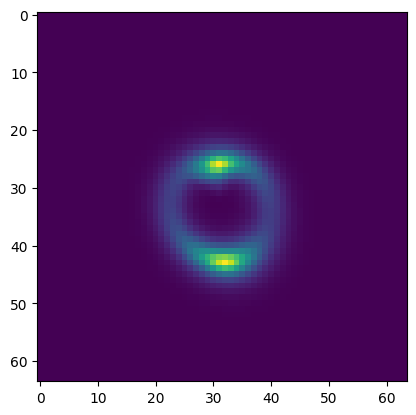

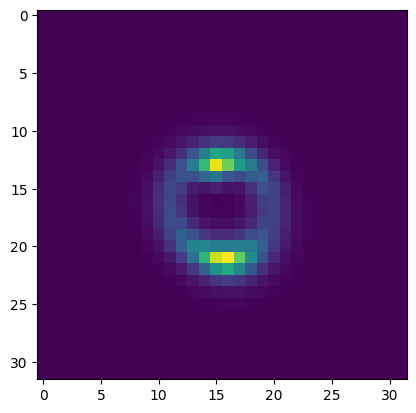

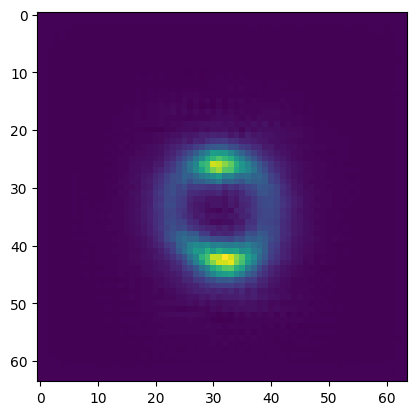

In [55]:
plt.imshow(HR[0,0])
plt.figure()
plt.imshow(LR[0,0])
plt.figure()
plt.imshow(SR[0,0])

## Setting up model

In [24]:
from ADDA.networks import resnet

encoder = resnet.Encoder('18')
classifier = resnet.Classifier()

/home/koo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/koo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Then we get the hyperparameters for the algorithm we're using:

In [25]:
from ADDA.data import hyperparams

hparams = hyperparams.supervised_hyperparams(wd=5e-5)

And finally we'll call the algorithm class and set it up:

In [26]:
from ADDA.algorithms import supervised

Supervised = supervised.Supervised(encoder, classifier)

## Train and evaluate the model

In [47]:
epochs = 10
save_path = "./resnet.pt"

encoder, classifier = Supervised.train(source_dataloader_train, source_dataloader_val, epochs, hparams, save_path)

100%|██████████| 90/90 [00:11<00:00,  7.92it/s]


[Epoch 1/10] loss: 0.263799; accuracy: 0.863333; val accuracy: 0.842778;


100%|██████████| 90/90 [00:02<00:00, 39.86it/s]


[Epoch 2/10] loss: 0.374673; accuracy: 0.706333; val accuracy: 0.710000;


100%|██████████| 90/90 [00:02<00:00, 41.37it/s]


[Epoch 3/10] loss: 0.453288; accuracy: 0.366000; val accuracy: 0.377778;


100%|██████████| 90/90 [00:02<00:00, 42.24it/s]


[Epoch 4/10] loss: 0.430793; accuracy: 0.778778; val accuracy: 0.757222;


100%|██████████| 90/90 [00:02<00:00, 41.77it/s]


[Epoch 5/10] loss: 0.389573; accuracy: 0.837667; val accuracy: 0.820556;


100%|██████████| 90/90 [00:02<00:00, 41.74it/s]


[Epoch 6/10] loss: 0.338092; accuracy: 0.874333; val accuracy: 0.876667;


100%|██████████| 90/90 [00:02<00:00, 41.35it/s]


[Epoch 7/10] loss: 0.286483; accuracy: 0.825556; val accuracy: 0.827778;


100%|██████████| 90/90 [00:02<00:00, 41.61it/s]


[Epoch 8/10] loss: 0.239692; accuracy: 0.921556; val accuracy: 0.916667;


100%|██████████| 90/90 [00:02<00:00, 41.22it/s]


[Epoch 9/10] loss: 0.200990; accuracy: 0.926444; val accuracy: 0.918889;


100%|██████████| 90/90 [00:02<00:00, 41.90it/s]


[Epoch 10/10] loss: 0.161493; accuracy: 0.930556; val accuracy: 0.922778;


/mnt/d/HKUST/y3/spring/comp5214/project/TaskIII/ADDA/algorithms/supervised.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load(save_path)


We can then print the model's training metrics:

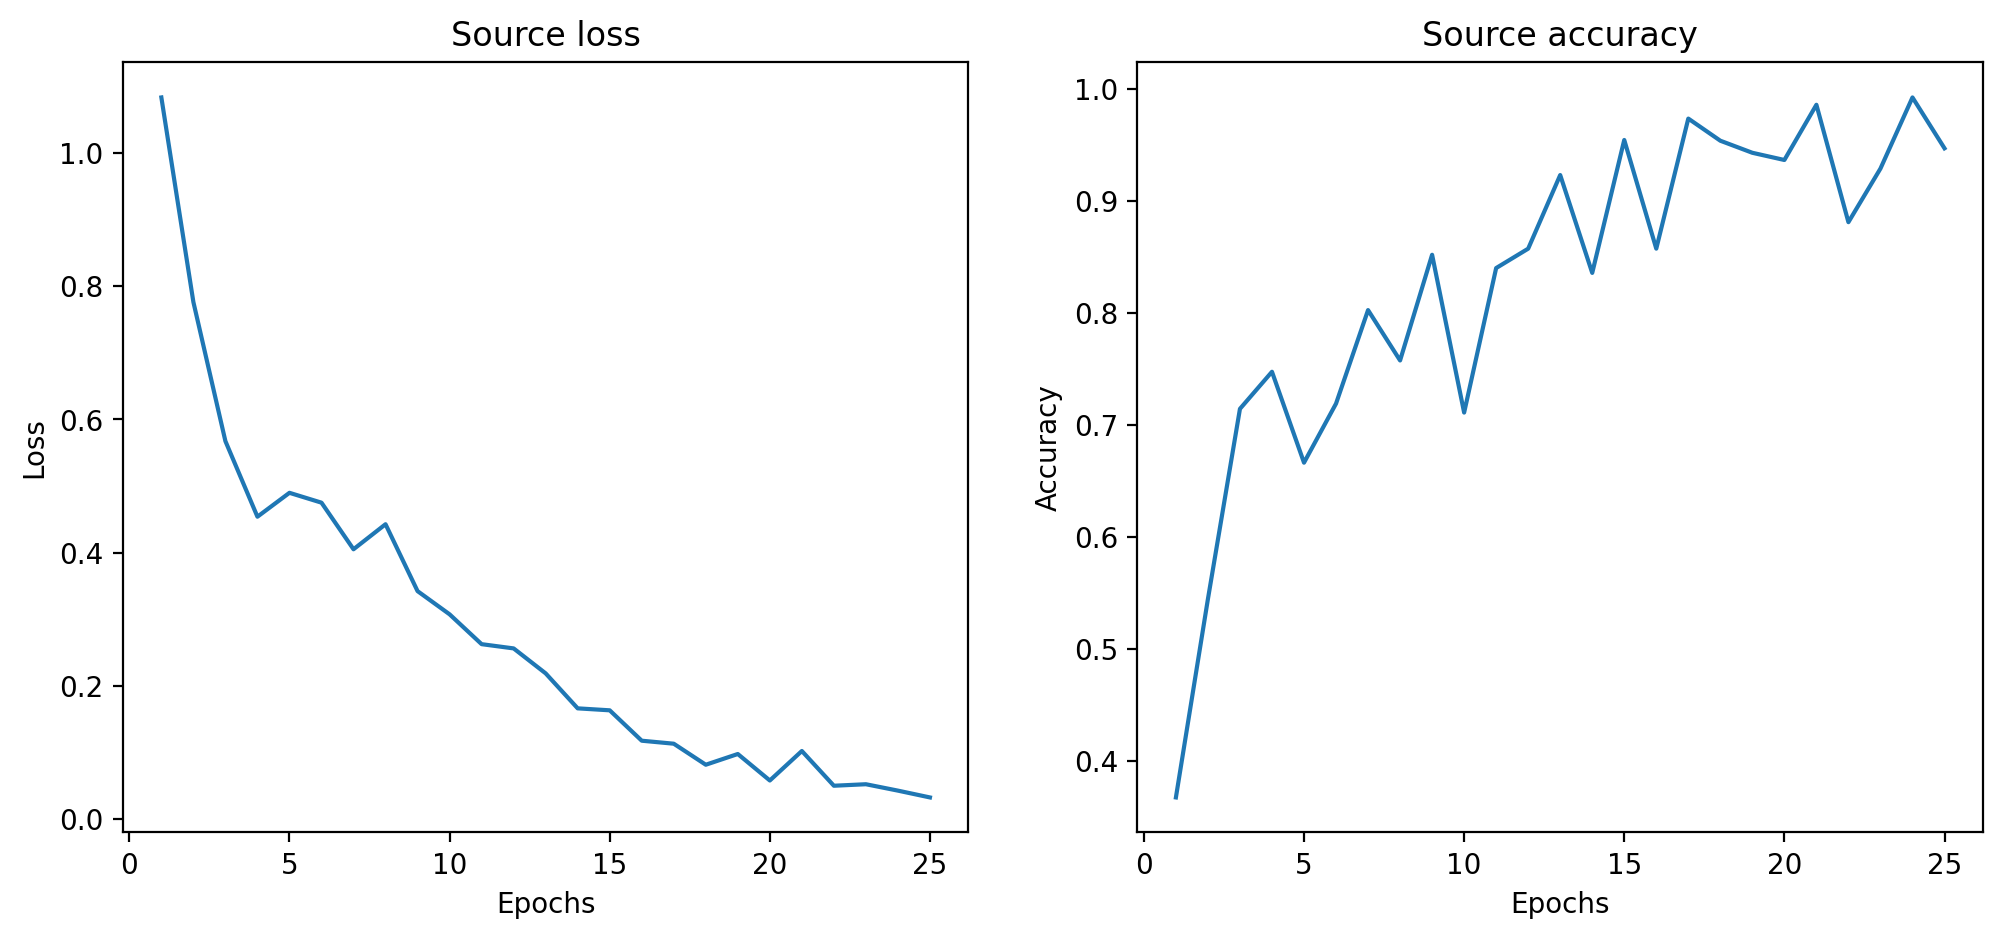

In [122]:
Supervised.plot_metrics()

And evaluate it on the test set:

accuracy on test set = 0.92


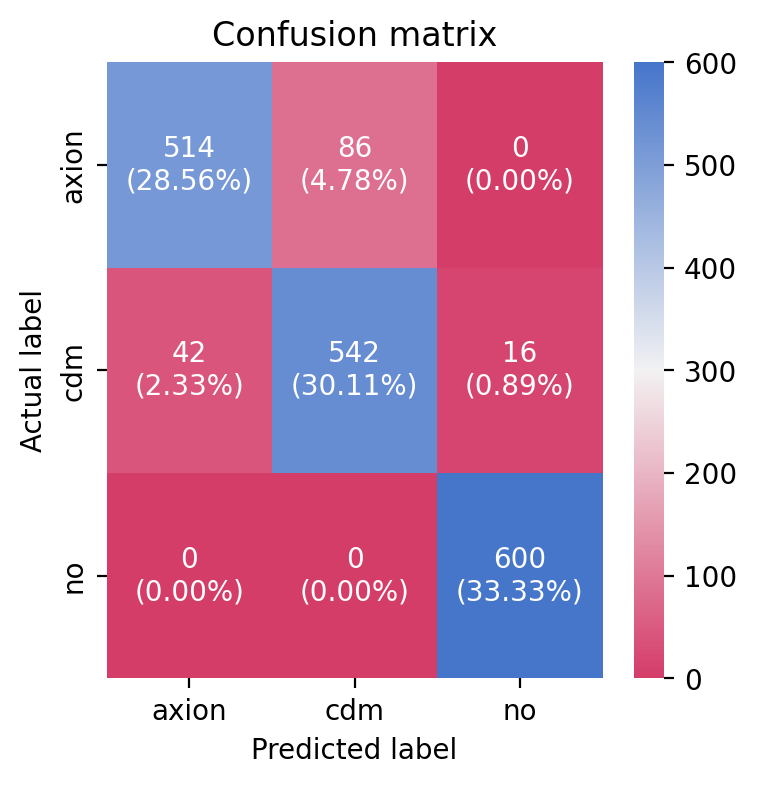

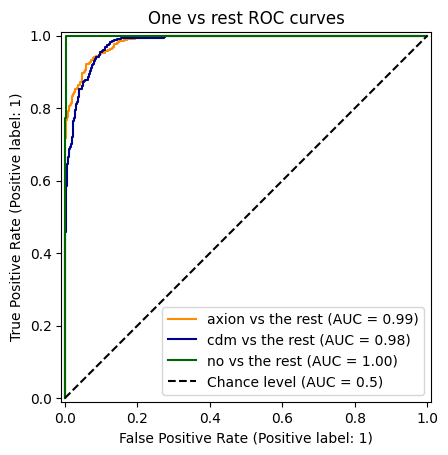

In [48]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

def plot_cm_roc(self, dataloader, output_path=None, n_classes=3):
    """
    Plots the confusion matrix and ROC curves of the model on `dataloader`.

    Arguments:
    ----------
    dataloader: PyTorch DataLoader
        DataLoader with test data.

    n_classes: int
        Number of classes.

    output_path: str
        Output path to .npz (NumPy) file containing the true positive rate, false positive rate
        and AUROC.
        To obtain the information, load the .npz file with `allow_picle=True` and select the data
        of interest with `array['tpr'].item()`, `array['fpr'].item()` or `array['roc_auc'].item()`.
    """

    cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)

    accuracy, labels_list, outputs_list, preds_list = self.evaluate(dataloader, return_lists_roc=True)
   
    #labellist: true labels
    #outputs_list: predicted labels
    # plot confusion matrix
    cm = sklearn.metrics.confusion_matrix(labels_list, preds_list)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(n_classes,n_classes)
    #tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(4,4), dpi=200)
    categories = ['axion', 'cdm', 'no'] #  0:axion 1:cdm 2:no 
    sns.heatmap(cm, annot=labels, cmap=cmap, fmt="", xticklabels=categories, yticklabels=categories)
    plt.title("Confusion matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()
    color=['darkorange','darkblue','darkgreen']
    # plot roc
    ## one hot encode data
    label_binarizer = LabelBinarizer().fit( labels_list)
    onehot = label_binarizer.transform(labels_list)
    fig, ax = plt.subplots()
    ax.set_title("One vs rest ROC curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for class_of_interest in range(n_classes):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        plot_chance_level =False
        ## get roc curve and auroc for each class
        if class_of_interest == n_classes-1:
            plot_chance_level=True
        display = RocCurveDisplay.from_predictions(
            onehot[:, class_id],
            outputs_list[:, class_id],
            name=f"{categories[class_of_interest]} vs the rest",
            color=color[class_of_interest],
            plot_chance_level=plot_chance_level ,
            ax=ax, 
        )
print(f"accuracy on test set = {Supervised.evaluate(source_dataloader_HR )}")
plot_cm_roc(Supervised,source_dataloader_HR  , output_path=None, n_classes=3)

accuracy on test set = 0.3333333333333333


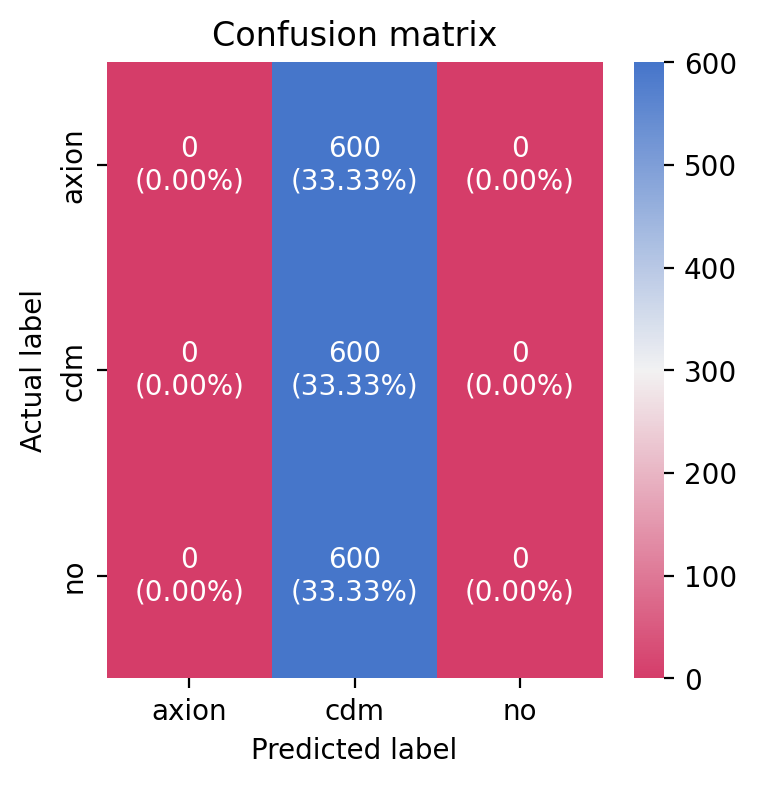

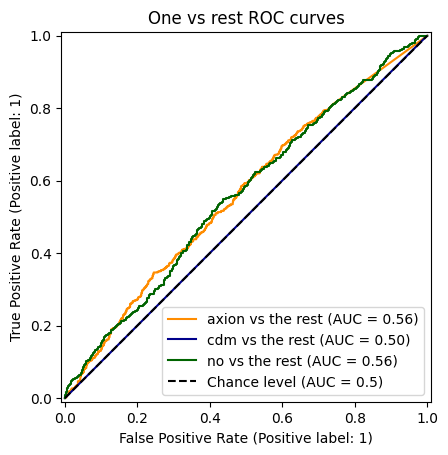

In [57]:
print(f"accuracy on test set = {Supervised.evaluate(source_dataloader_SR )}")
plot_cm_roc(Supervised,source_dataloader_SR , output_path=None, n_classes=3)

accuracy on test set = 0.3416666666666667


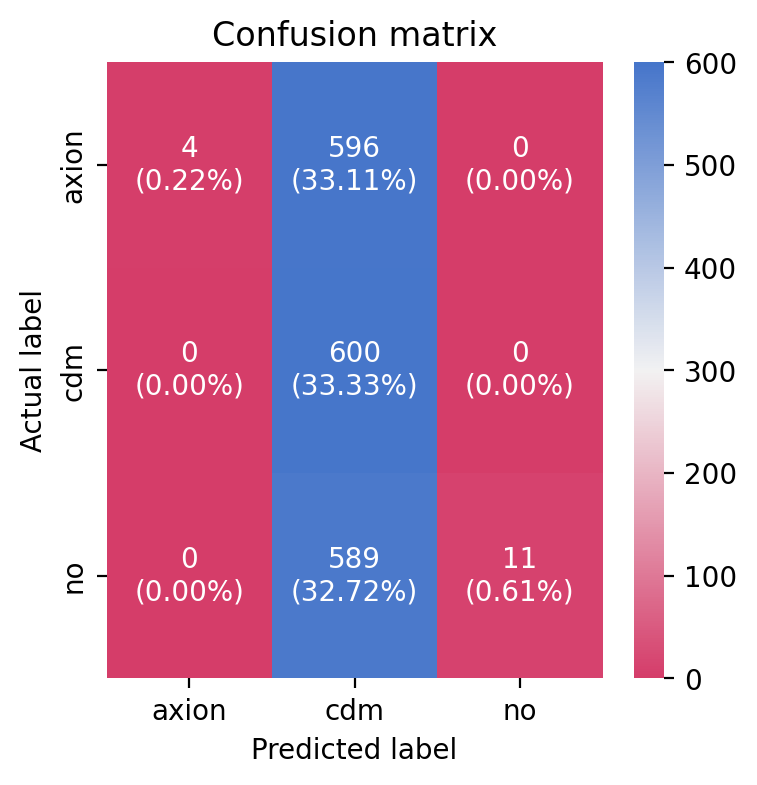

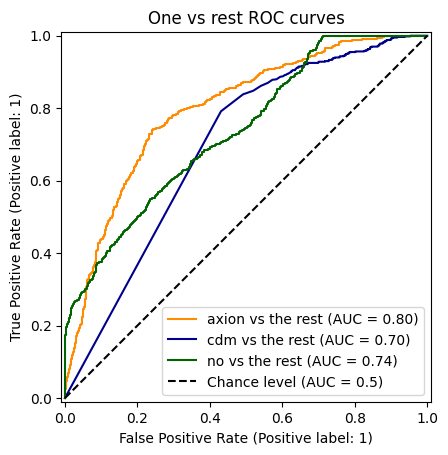

In [50]:
print(f"accuracy on test set = {Supervised.evaluate(source_dataloader_LR )}")
plot_cm_roc(Supervised,source_dataloader_LR , output_path=None, n_classes=3)

## Loading data

## Setting up model

Get the hyperparameters for ADDA:

Instantiate ADDA:

### Train and evaluate the model


We can then print the training metrics:

And evaluate it on the test set: